In [1]:
import pandas as pd
import numpy as np
import cloudpickle
import sklearn

from sklearn.preprocessing import StandardScaler
preprocessor = StandardScaler()

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

df=pd.read_csv("../../assets/assignment/df_train.csv.gz")
#df = df['overall_ranking'].dropna()
events=df['event.id'].unique()

# 80-10-10 Split
#train_set=events[0:234825]
#holdout_set=events[234826:264178]
#test_set=events[264179:293533]



train_set=events[0:100]
test_set=events[100:200]
holdout_set=events[200:300]

train=df.query("`event.id` in @train_set")
test=df.query("`event.id` in @test_set")
holdout=df.query("`event.id` in @holdout_set")

In [2]:
holdout=holdout.drop(
    columns=['time.end',
             'body.results_certificate',
             'event.results_posted',
            'event.results_posted',
             'event.results_certificate',
             'event.photos_available',
             'event.photos_faces',
             'event.photos_social_sharing',
             'event.results_searchable',
             'corral.id',
             'corral.name',
             'corral.wave',
             'corral.time.close',
             'corral.time.start',
             'result.duration.chip',
             'result.duration.pace',
             'result.rankings',
             'result.splits',
             'result.videos',
             'result.finished',
             'result.disqualified',
             'result.duration'])

# Also, I will garuntee in the holdout set there is data. At least 6 rows per race
holdout=df.groupby(["event.id","clean_categories.name"]).filter(lambda z: len(z)>5)

In [3]:
y=pd.to_timedelta(train['result.duration.chip']).astype(int)

In [4]:
# Step 2: Use the autograder!

# I gave you the autograder code, so a next great step is just to copy and paste
# that in your notebook and get used to how it works.
import pandas as pd
import numpy as np
import cloudpickle
import sklearn

# This code simulates the autograder. It is not the full autograder implementation
# but shares an API with the autograder. It expects that your fitted pipeline is
# submitted with the name pipeline.cloudpickle as demonstrated above. This object
# must implement the predict() function. This is done automatically by the sklearn
# Pipeline object if the last element of your pipeline is a classifier which has
# a predict() function. If you are not submitting a Pipeline, and want to do something
# different, you *must* have a predict() function of the same method signature, e.g.:
#
#   predict(self, X, **predict_params)->np.ndarray

# Load holdout data, in this case I'll simulate it by loading the training data
#df=pd.read_csv("../../assets/assignment/df_train.csv.gz")

# And evaluate on all 5k races that we didn't consider for training
#holdout_data=df.query("`event.id`!='583f013a-1e54-4906-87f7-2b625206f5f9' and `clean_categories.name`=='5k'")
holdout_data=holdout

# This is the scoring function to determine model fitness
def score(left: pd.DataFrame, right: pd.DataFrame):
    '''
    Calculates the difference between the left and the right when considering rank of items. 
    This scoring function requires that the two DataFrames have identical indicies, and that
    they each contain only one column of values and no missing values.
    '''
    assert(type(left)==pd.DataFrame)
    assert(type(right)==pd.DataFrame)
    assert(len(left)==len(right))
    assert(not np.any(np.isnan(left)))
    assert(not np.any(np.isnan(right)))
    assert(left.index.equals(right.index))
    # convert to ndarrays
    left=left.squeeze()
    right=right.squeeze()
    return np.sum(np.abs(left-right))/(len(left)*(len(left)-1))

# This function runs the prediction model agains a given event/category pair. It
# intentionally loads the student model each time to avoid accidental leakage of data
# between events.
def evaluate(data, pipeline_file='pipeline.cloudpickle'):
    # Load student pipeline
    fitted_pipe = cloudpickle.load(open(pipeline_file,'rb'))
    
    # Separate out the X and y
    X=list(set(data.columns)-{'overall_ranking'})
    y=['overall_ranking']
    
    # Drop any missing results (DNFs)
    data=data.dropna(subset=['overall_ranking'])
    
    # Ensure there is data to actually predict on
    if len(data)==0:
        return np.nan
    
    # Predict on unseen data
    from IPython.utils import io
    with io.capture_output() as captured:
        predictions=pd.DataFrame(fitted_pipe.predict(data[X]),data.index)
    observed=data[y]
    
    # Generate rankings within this bracket
    observed=pd.DataFrame(data[y].rank(),data.index)

    # Return the ratio of the student score
    return pd.Series({"score":score(observed,predictions)})

# Student solution
pipeline_file='pipeline.cloudpickle'

def autograde(holdout_data):
    # Run prediction on each group
    results=holdout_data.groupby(["event.id","clean_categories.name"]).apply(evaluate, pipeline_file)

    # Display the results, uncomment this for your own display
    results.reset_index()['score'].plot.bar();

    # This is the student final grade
    print(np.average(results))

In [5]:
# That assignment should pass the autograder. A more pythonic way to do this, and certainly
# the goal of the sklearn team, is to use pipelines, and reuse transformer objects to do the
# data cleaning. In sklearn pipelines are made up of a sequence of Transformers with the last
# item in the pipeline being an Estimator. You can have Estimators throughout the pipeline
# too, creating new features through modeling. For instance, you could use PCA to reduce the
# dimensionality of features and then learn on principal components instead.

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))

# We can write a similar model to the above using pipelines and transformers. A good example
# would be to first create a transformer for the columns of sex and age, and get rid of
# everything else while one hot encoding sex

df.loc[df.query("`age` >= 119").index, 'age']=np.nan
df.loc[df.query("`age` <= 18").index, 'age']=np.nan
df.loc[df['age'] == 'nan', 'age'] = 38

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
cleaner = ColumnTransformer(
    transformers=[
        ("sex", OneHotEncoder(categories=[['Male','Female']], handle_unknown='ignore'), ['sex']),
        ('age', 'passthrough', ['age']),
        ('clean_categories.name', OneHotEncoder(categories=[['15k', '5k', 'marathon', 'half marathon', '10k', '5 mile', '8k',
       '5k run', '3k walk', '10k run', 'youth mile', '5k run/walk',
       '5k walk', '5 mile run', '1 mile run', '15k run', '10k walk',
       '6k run', '6k walk', '1 mile walk', '8k run', '8k walk',
       '10 mile run', '10 mile walk', '5 mile walk', '30k run',
       '30k bike', '8 mile run', '8 mile walk', 'bridge run',
       'international half marathon', 'u.s. only half marathon', '1 mile',
       '5.7 mile run', '5.7 mile walk', '5k competitive walk',
       'half marathon run', '5k fun walk', '5k wheelchair',
       '1 mile fun run', '2 mile run', '2 mile walk', '4 mile run/walk',
       'life time commitment day 5k', 'midnight streak',
       'commitment day 5k - master', 'quarter marathon', '5k walk/run',
       '1 mile fun run/walk', 'one mile fun run', '5 km run',
       'fire fighter', 'olympic triathlon', 'sprint triathlon',
       'olympic duathlon', 'sprint duathlon', '10k scenic challenge',
       'run swim run', 'half marathon walk', 'mini-marathon']], handle_unknown='ignore'), ['clean_categories.name']),
        ('body.type', OneHotEncoder(categories=[['Run','nan']], handle_unknown='ignore'), ['body.type']),
        ('body.timezone', OneHotEncoder(categories=[['America/Boise', 'America/Los_Angeles', 'America/Denver',
       'America/New_York', 'America/Chicago', 'America/Detroit']], handle_unknown='ignore'), ['body.timezone']),
        ('location.state', OneHotEncoder(categories=[['AZ', 'CA', 'CO', 'FL', 'GA', 'IL', 'IN', 'MI', 'MN', 'MO', 'NM',
       'NC', 'OH', 'OK', 'OR', 'PA', 'TN', 'TX', 'VA', 'WA', 'WV', 'WI']], handle_unknown='ignore'), ['location.state']),
        ('location.city', OneHotEncoder(categories=[['Scottsdale', 'San Francisco', 'San Diego', 'Arcata', 'Denver',
       'Tampa', 'Atlanta', 'Chicago', 'Highland Park',
       'Elk Grove Village', 'Oak Park', 'Indianapolis', 'Port Huron',
       'Flint', 'Swartz Creek', 'Royal Oak', 'Pinconning', 'Roscommon',
       'Plymouth', 'Algonac', 'Fenton', 'Detroit', 'Pigeon',
       'Bloomfield Hills', 'Rogers City', 'Caseville', 'Montrose',
       'Milford', 'Mackinac Island', 'Sault Ste. Marie', 'East Lansing',
       'Williamston', 'Howell', 'Minneapolis', 'St. Louis', 'Santa Fe',
       'Charlotte', 'Columbus', 'Canal Fulton', 'Brewster', 'Hartville',
       'Strasburg', 'North Canton', 'Clinton', 'Cadiz', 'Dalton',
       'Alliance', 'Barberton', 'Millersburg', 'Peninsula', 'Bolivar',
       'Massillon', 'Canton', 'Akron', 'Oklahoma City', 'Tulsa',
       'Oklahoma City, OK', 'Norman', 'Edmond', 'Lawton', 'Stillwater',
       'Moore', 'Perry', 'Seiling', 'Bethany', 'Elk City', 'Sulphur',
       'Yukon', 'Beaverton', 'Salem', 'Albany', 'Philadelphia',
       'Nashville', 'Houston', 'Dallas', 'Virginia Beach', 'Fairfax',
       'West Point', 'Seattle', 'Parkersburg', 'Milwaukee']], handle_unknown='ignore'), ['location.city']),
        ('event.id', OneHotEncoder(categories=[['583f013a-1e54-4906-87f7-2b625206f5f9',
       '5a0dec07-5730-4099-b7a9-6cc05206f5f9',
       '5840463a-70d0-46c2-8954-6dbf5206f5f9',
       '58405447-64f8-44f8-a81f-01985206f5f9',
       '5a5b9a23-ecfc-46ef-8c9f-01e45206f5f9',
       '57ed3e2f-5ee8-4195-acf7-4ea75206f5f9',
       '59c93fda-556c-4a1c-8609-13895206f5f9',
       '583f31b0-c090-4558-b0f6-46c65206f5f9',
       '5a2d3288-0390-4f2e-a09a-3b065206f5f9',
       '58404d26-eaa8-4c04-82e5-7d045206f5f9',
       '5c5cb866-391c-404a-a9f7-540a5206f5f9',
       '57bdcd1f-a474-43e0-8e54-5f3a5206f5f9',
       '57f3d359-f5d4-4a03-b9f3-29a15206f5f9',
       '58fa2ce7-8fe8-4fdc-9675-32785206f5f9',
       '590b73b9-2960-4c3f-8b5e-31b35206f5f9',
       '59318b7f-12a8-4e32-917b-7b435206f5f9',
       '5af9d47d-8c68-4bd0-bee8-58085206f5f9',
       '5a317d2c-c22c-4c30-bfab-245c5206f5f9',
       '59e90517-5ed0-4796-95fd-77225206f5f9',
       '5a8717a6-4e94-4cb0-8a25-0a5c5206f5f9',
       '59a99331-e614-4004-8634-16bc5206f5f9',
       '59af0a5d-513c-4ed7-9daf-6d845206f5f9',
       '5af9a8b2-06a4-40b4-acf6-07ea5206f5f9',
       '59c2bd2d-fc20-4efb-86a1-33955206f5f9',
       '5a3039c7-7a38-4d18-a7d7-5b765206f5f9',
       '590b4d4c-1110-47b9-af8b-202e5206f5f9',
       '5a09be9b-336c-4208-a96c-2d505206f5f9',
       '5a4d1178-d4d0-4a04-95b5-54d85206f5f9',
       '59230b2f-bdb4-45cc-b3ff-76e55206f5f9',
       '5a81ddce-186c-4903-adc8-21565206f5f9',
       '5a565410-6288-4eeb-8f45-78ea5206f5f9',
       '5aa1a8ff-1294-4b04-9044-576b5206f5f9',
       '5a980634-efb4-4849-aa0f-17b05206f5f9',
       '5a8206d3-d2b4-49b3-843b-11bc5206f5f9',
       '5a58fc3d-37d4-43a1-992b-45a55206f5f9',
       '5a562b13-b310-42d6-badf-1ad65206f5f9',
       '5a70fdf7-cb30-440e-af77-14f75206f5f9',
       '5ad8ae00-e10c-4a35-a5c6-5cb35206f5f9',
       '5abeadde-ace8-46e4-b456-0fea5206f5f9',
       '5aba67c1-a8c8-4f55-a83a-3a0a5206f5f9',
       '5aa9724c-b8a8-47e5-98cc-21e65206f5f9',
       '5ade1d25-f28c-4137-a080-64105206f5f9',
       '5ad385d7-fcd4-423e-ac99-33625206f5f9',
       '5b687f64-1074-4f2d-88ca-3d365206f5f9',
       '5b217282-ef14-4990-a436-20f55206f5f9',
       '5b2bb89e-3204-461e-b6a1-099f5206f5f9',
       '5b6b34d6-40b8-483c-826e-68525206f5f9',
       '5a43b245-4738-4607-8ed3-1f3c5206f5f9',
       '59a4a07f-fa60-4de0-911c-699a5206f5f9',
       '5a302f88-f984-4076-aaa1-47c15206f5f9',
       '5b153ba0-5f0c-41e7-959c-3fcf5206f5f9',
       '5b7adab1-2654-4345-9cc2-0a785206f5f9',
       '5b92ca90-34e0-4019-a17b-52bb5206f5f9',
       '59a06537-01fc-4bc1-81b7-7ad25206f5f9',
       '5b5a2703-9660-4860-b221-32ca5206f5f9',
       '58405524-3c70-49fc-a996-6dbf5206f5f9',
       '583f2c80-ea88-48bd-a4ba-3f035206f5f9',
       '5a1c7352-b910-474e-86c1-40705206f5f9',
       '5c6b6a37-8198-40cd-8442-67fc5206f5f9',
       '5c6b6b95-7668-471c-934c-5ddb5206f5f9',
       '590a3af0-8e04-4e06-ae1b-12405206f5f9',
       '583352f9-d400-4da5-a7c8-48645206f5f9',
       '59df7a08-d680-41a2-b33e-2eae5206f5f9',
       '5a257762-6988-416b-8f13-1f735206f5f9',
       '5a4693eb-0408-48d9-ad3c-306c5206f5f9',
       '5a6740c3-72d8-4fc3-a844-735e5206f5f9',
       '59fba6af-bbe4-442d-972e-3d715206f5f9',
       '5a7345e7-3ee8-4b47-a700-30f15206f5f9',
       '5a13452c-8df0-4900-8616-2e185206f5f9',
       '5a60be6b-8038-4793-b9eb-23255206f5f9',
       '5a14428f-9d48-4017-a644-6e8d5206f5f9',
       '5a4f98e5-4e38-466e-8669-122a5206f5f9',
       '59a2e4ef-2f84-4dd6-a7fe-3ed15206f5f9',
       '5a2ec6eb-8c24-4e9c-87aa-41bd5206f5f9',
       '59dd4424-fe1c-485c-b6cd-1b485206f5f9',
       '5a4fd1c7-b21c-4023-b545-263f5206f5f9',
       '5a53aa79-184c-47a6-a2a3-313a5206f5f9',
       '5a2ace7a-7b24-4d2a-b676-6c9d5206f5f9',
       '5a8ae3f2-7158-495b-ba25-3c085206f5f9',
       '59ea2b38-4154-40c8-8aed-6b395206f5f9',
       '5a57b9dd-93f0-4abd-81c8-28bc5206f5f9',
       '5a66533b-d89c-4478-8f6c-37015206f5f9',
       '5a9efd91-b278-458b-9eb4-608a5206f5f9',
       '5c6b4275-d2d4-4c55-98a6-44785206f5f9',
       '5c87e429-1794-419e-8c84-08485206f5f9',
       '5c6b457c-e7dc-47cb-bba7-34db5206f5f9',
       '5c7fe534-32c8-45dc-8f21-01bf5206f5f9',
       '5c87e6c4-ae88-4da5-ab6d-0e975206f5f9',
       '5c6b4b03-157c-4a28-8236-1c545206f5f9',
       '5c7ff378-5284-49ef-90d3-31965206f5f9',
       '5c6c391e-8e18-4106-8e5a-7aaf5206f5f9',
       '5c6c733f-631c-42a9-9b02-11855206f5f9',
       '5c6b4dbc-f87c-463c-962e-19915206f5f9',
       '5c8941fc-5b00-4c1d-8063-5a7e5206f5f9',
       '5c803365-3704-4b3f-8c79-5bfb5206f5f9',
       '5c87ee2c-3534-46ba-a49e-08485206f5f9',
       '5c6c3c5b-94cc-4f8d-8833-128e5206f5f9',
       '5c6c7600-7848-414e-a503-2ca25206f5f9',
       '5c802215-eb68-415c-8b78-76555206f5f9',
       '5c6b5dbd-ad4c-4558-aecf-5dbe5206f5f9',
       '5c802a0a-6190-483b-bd7c-19725206f5f9',
       '5c6b30ac-036c-4073-b9e4-198e5206f5f9',
       '5c818e6a-0cd4-443a-8d8f-46285206f5f9',
       '5c6b3aa2-9b50-43ea-908e-0e4a5206f5f9',
       '5c87f0b2-d280-40bd-a827-15405206f5f9',
       '5c892c06-6cf0-468b-872d-68695206f5f9',
       '5c8025b5-e930-4ab5-b87c-19715206f5f9',
       '5c89333f-b684-4593-b87c-7aac5206f5f9',
       '5c66f565-61d0-4834-9d32-6c675206f5f9',
       '5c6b5e5a-00cc-4c97-a95b-5dd95206f5f9',
       '5c6b3572-56a0-4d27-a23e-44785206f5f9',
       '5c6c70fc-fd20-4769-9ee1-088e5206f5f9',
       '5c802fca-1ee4-4f10-a2be-0e805206f5f9',
       '5c89366f-5600-491a-9c27-1f965206f5f9',
       '5c82ba4e-aca8-40d8-9ed8-0cbe5206f5f9',
       '5c6b3f3c-2ba0-4dad-8764-19915206f5f9',
       '5c6c7c8b-bde8-4bc9-91ef-533d5206f5f9',
       '5c7fdb4d-3688-46a2-b808-45615206f5f9',
       '5c82ca25-1eec-4427-871f-7b095206f5f9',
       '5c87f30e-bf94-41ab-b234-15415206f5f9',
       '5c6b5ef7-6c28-4774-afbc-67d45206f5f9',
       '5c893fc1-44d8-48e7-8844-5a785206f5f9',
       '5c019c1b-b370-4732-aa47-1db25206f5f9',
       '5bcf4f57-8658-4484-84b4-165c5206f5f9',
       '59b6bd5d-1008-4d2c-8194-263b5206f5f9',
       '5a54f181-e37c-41da-9f62-42925206f5f9',
       '5a393a3a-7628-4bce-b9ea-556b5206f5f9',
       '584054cb-f3d8-4c38-b560-03135206f5f9',
       '5840533c-27a0-4c85-8603-7a475206f5f9',
       '590a3e6e-ac64-4341-af5b-18165206f5f9',
       '5840528b-6010-4133-8fef-7d065206f5f9',
       '5e862221-758c-48b1-a7cf-11bcc0a80a41',
       '5e860049-7e9c-4f9d-9911-37c4c0a80a41',
       '5e8622bc-0ef4-472a-a19b-6f4bc0a80a41',
       '5e83a2da-3c78-430f-95aa-236fc0a80a41',
       '5e86018d-79d4-4d30-998e-69e6c0a80a41',
       '5e862439-c108-40be-b3ec-36b6c0a80a41',
       '5e791e51-81d0-48f5-a6c1-31e3c0a80a41',
       '59f0f5dc-31bc-41b6-860b-0a415206f5f9',
       '5e83a579-e5c4-45a1-82bd-792ec0a80a41',
       '5e86031d-5590-4c2b-97a6-44d6c0a80a41',
       '5d24927d-161c-4287-9ef7-7494c0a80a41',
       '58405401-f23c-46b2-8dfc-032d5206f5f9',
       '5a5e3aba-95d4-4577-bbe8-67375206f5f9',
       '5b7ae951-7e04-4262-a599-2f745206f5f9']], handle_unknown='ignore'), ['event.id']),
         ('event.tenant.name', OneHotEncoder(categories=[['Ventures Endurance', 'Avenue of the Giants Marathon',
       'Lincoln Park Zoo', 'Strides for Peace Run/Walk',
       'Leukemia Research Foundation', 'Chicago Bears',
       'Greater Illinois Pediatric Palliative Care Coalition',
       'Frank Lloyd Wright Races', 'Worldwide Sport and Social Club',
       'St. Clair County Mental Healthy Authority',
       'Genesee County Free Medical Clinic', 'Riverbend Striders',
       'Everal Race Management', 'CheeseTown Races',
       'Higgins Lake 5K/10K/Half Marathon', 'Plymouth YMCA',
       'Pickerel Run', 'Habitat for Humanity - Genesee County',
       'Scheurer Hospital', 'Atwood 10K Committee', 'Crim Foundation',
       'Milford Labor Day 30K', 'RunMackinac Events', 'Dino Dash',
       'EnMotive Michigan', 'Detroit Marathon',
       'Howell Area Chamber of Commerce', 'EnMotive OKC',
       'Ohio Challenge Series', 'HCCC ColorRun ', 'Bowerman 5k ',
       'Rotary River Fest Salem', 'Corvallis Lions Club',
       'LifeNet Health', 'Allen Stone Memorial Races',
       'Chesapeake Beach Civic League', 'Commonwealth Race Management',
       'Town Of West Point', 'Cape Henry Collegiate',
       'News And Sentinel Half Marathon',
       'Milwaukee Brewers Baseball Club']], handle_unknown='ignore'), ['event.tenant.name']),
        

         ('result.primary_bracket', OneHotEncoder(categories=[['Overall','Wheelchair','Male','Female']], handle_unknown='ignore'), ['result.primary_bracket']), 
    ], remainder='drop')

# Then we create a three stage pipeline, where the first step applies the column transformer,
# the next step fills our missing values, and the third step is a regression model. But remember,
# this isn't a simple regression, we need an ordinal classification. To do this we can wrap
# the linear regressor in another class which will transform the regression output. This class
# is called the TransformedTargetRegressor, and we can tell it what function we want to apply
# to the final output before returning the predictions.

def evaluation_function(x):
    '''Must return a ndarray of the rankings in order, the autograder will then create
    a dataframe out of this with x.index as the index. Props to Rachell Calhoun!'''
    return pd.Series(x.squeeze()).rank().values

# We can wrap a linear regressor by setting the inverse_func to evaluation_function
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression
reg=TransformedTargetRegressor(regressor=GradientBoostingRegressor(loss='squared_error', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, init=None, random_state=None, max_features=None, alpha=0.9, verbose=0, max_leaf_nodes=None, warm_start=False, validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0), inverse_func=evaluation_function)

# Now we can build our three part pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
pipe = Pipeline(
    steps=[
        ("cleaner", cleaner),
        ("fix_nans", SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ("regressor", reg)
    ])

# We can display the pipeline to see what it looks like and get a sense of data flow
from sklearn import set_config
set_config(display="diagram")
display(pipe)

Pipeline(steps=[('cleaner',
                 ColumnTransformer(transformers=[('sex',
                                                  OneHotEncoder(categories=[['Male',
                                                                             'Female']],
                                                                handle_unknown='ignore'),
                                                  ['sex']),
                                                 ('age', 'passthrough',
                                                  ['age']),
                                                 ('clean_categories.name',
                                                  OneHotEncoder(categories=[['15k',
                                                                             '5k',
                                                                             'marathon',
                                                                             'half '
                                                                             'marathon',
                                                                             '10k',
                                                                             '5 '
                                                                             'mile',
                                                                             '8k',
                                                                             '5k '
                                                                             'run',
                                                                             '3k '
                                                                             'walk',
                                                                             '10k '
                                                                             'run',
                                                                             'youth '
                                                                             'mile',
                                                                             '5k '
                                                                             'run/walk',
                                                                             '5...
                                                  ['event.tenant.name']),
                                                 ('result.primary_bracket',
                                                  OneHotEncoder(categories=[['Overall',
                                                                             'Wheelchair',
                                                                             'Male',
                                                                             'Female']],
                                                                handle_unknown='ignore'),
                                                  ['result.primary_bracket'])])),
                ('fix_nans', SimpleImputer(strategy='most_frequent')),
                ('regressor',
                 TransformedTargetRegressor(inverse_func=<function evaluation_function at 0x7f2dead00550>,
                                            regressor=GradientBoostingRegressor()))])

<Figure size 864x576 with 0 Axes>

0.3907230319899751


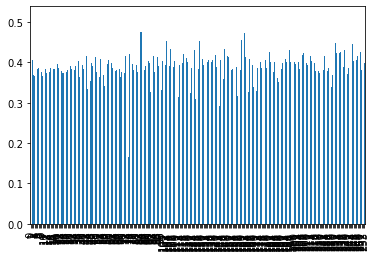

In [6]:
# We can then fit the data in the pipeline
fitted_pipe=pipe.fit(train,y)

# And we can save it to an output file
cloudpickle.dump(fitted_pipe, open('pipeline.cloudpickle','wb'))
# Then telling the autograder function to fire
autograde(holdout_data)